# Pairs Trading

**The Pairs Trading is a trading strategy that takes advantage of the fact that certain assets tend to move in sync**, which means that the spread between them tend to revert to some mean over time.

Imagine two companies that operate in the same sector. Even though their share value are different and unique to its company, they are both impacted by dips and highs on the market that they both belong to. So if demand goes up or down in that sector, both companies are affected by it. A trader could recognize this pattern and create a Pairs Trading strategy when the spread between the two stocks increase.

So for example, if the price of stock A increases, while the price of stock B remains the same, the trader would go long (buy) stock B and go short (sell) on stock A. The assumption is that the spread will close over time, reverting to a certain mean and resulting in profit.

**A condition for this strategy to work is that the spread between the two assets is stationary.** This pattern can be found in **cointegrated variables**, which demonstrate long-term stable relationships.

This strategy is considered to be **market-neutral**, because it aims to profit from the relationship between two assets and not from the direction of the overall market. By holding both a long and a short position, your exposure to broad market risk is significantly reduced.

# Data Analysis

For this exercise, we'll first look for two stocks that could be used in a pair trading strategy by using some statistical tools and then try a moving average method to apply the strategy.

## Importing Libraries

We are going to use `pandas` and the `datetime` library for DataFrame manipulation, `matplotlib` and `seaborn` for plotting graphs and the `yfinance` library to retrieve stock prices.

In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Function to Retrieve Historical Prices

To get the historical closing prices, we first create a function to retrieve the data, using the `yfinance` library. This function takes as inputs the tickers of each stock in an array and optionally, the start and end dates for the timeseries.

In [ ]:
def get_historical_data(tickers, start=datetime(2020, 1, 1), end=datetime(2025, 1, 1)):
    """
    Iterates through the tickers list, getting all the closing prices
    for each ticker from a start date until a end date
    """

    data = pd.DataFrame()
    
    # Iterate through all the tickers
    for ticker in tickers:
        try:
            # Request the closing prices
            df = yf.Ticker(ticker).history(start=start, end=end)['Close']
            df.index = df.index.date
        except:
            pass
        
        data = pd.concat([data, df], axis=1)

    data.columns = tickers
    
    return data

## Getting a List of Companies from the Bovespa Index

As an example, I'll be searching for pairs within the Brazilian stock market's Bovespa Index. To get the tickers for each company, I'll scrape the table on the Ibovespa's Wikipedia page. We're also adding the Bovespa index itself.

In [3]:
# Reads the Wikipedia page to obtain the tickers
table = pd.read_html('https://pt.wikipedia.org/wiki/Lista_de_companhias_citadas_no_Ibovespa')[0]
ibov_tickers = table['Código'].tolist()
ibov_tickers = [tick + '.SA' for tick in ibov_tickers] + ['BOVA11.SA']

## Retrieving Historical Closing Prices from the Ibovespa Companies

In [4]:
df = get_historical_data(ibov_tickers)
df.dropna(axis=1, inplace=True)

HTTP Error 404: 
$CCRO3.SA: possibly delisted; no timezone found
$CIEL3.SA: possibly delisted; no timezone found
$CRFB3.SA: possibly delisted; no timezone found
$GOLL4.SA: possibly delisted; no price data found  (1d 2020-01-01 00:00:00 -> 2025-01-01 00:00:00) (Yahoo error = "No data found, symbol may be delisted")
$JBSS3.SA: possibly delisted; no timezone found


## Selecting a Pair of Stocks

### Cointegration

We're looking for [cointegrated pairs](https://en.wikipedia.org/wiki/Cointegration), which means that **in the long run, the two stocks tend to move together**. If the price of the two stocks move together in the long-term, the spread between them also has a tendency to revert to some mean from time to time.

To check the cointegration between two stocks, we'll use the `ts.coint()` method from the `statsmodels` library. If the p-value for the cointegration test is less than 0.05, we'll reject the null hypothesis, and consider the two variables to be cointegrated.

In [5]:
import statsmodels.tsa.stattools as ts

pairs = []
cointegrated_pairs = []

# Iterate through all the pairs
for i in df.columns:
    for j in df.columns:

        # Skip the pairs that were already seen
        if i == j or set([i, j]) in pairs:
            continue

        # Get the p-value for the cointegration test
        coint = ts.coint(df[i], df[j])[1]

        # If the p-value is smaller than 0.05, we can consider it to be cointegrated
        if coint < 0.05:
            cointegrated_pairs.append((i, j))

        pairs.append(set([i, j]))

One thing to be careful with is the [Multiple Comparison Problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). Since the statistical test has a p-value threshold of 0.05, it means that 5% of time the pairs will be considered cointegrated, even though they are not. One way to mitigate this issue is to second check the two stocks, and look for other reasons to why the two assets should be cointegrated.

For example, if we find out that the stock prices of two companies are cointegrated, one that operates in the education sector and another that operates in the transportation sector, it should raise the suspicion that it’s just random noise, requiring a second test.

To understand more about cointegration, I recommend watching Ben Lambert's video presented at the end of this article.

### Stationarity

[Stationary variables](https://en.wikipedia.org/wiki/Stationary_process) are stochastic process whose **mean and variance do not change over time**. In other words, they tend to revert back to that mean, while its variance remains the same. Cointegrated pairs should result in stationary spreads, but we will also filter out from the cointegrated pairs, assets that don't show a stationary spread.

If two variables are cointegrated, the difference between the two over time does not necessarily stay the same. That is because **cointegration does not count for the scale that each variable moves**. One stock might double while the other triples, and they could still be cointegrated if the ups and downs stay consistent over time.

For that reason, instead of calculating a simple spread between the two stock prices, **we'll fit a linear regression, looking for a beta coefficient, which represents the ratio in which one stock moves more or less than the other**.

In [6]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

cointegrated_stationary_spread = []

for pair in cointegrated_pairs:
    stock1 = pair[0]
    stock2 = pair[1]

    # Fit a linear regression to get beta
    S1 = sm.add_constant(df[stock1])
    results = sm.OLS(df[stock2], S1).fit()
    beta = results.params[stock1]

    # Calculate the spread
    spread = df[stock2] - beta * df[stock1]

    # Check if the spread and the ratio are stationary
    if adfuller(spread)[1] < 0.05 and adfuller(df[stock1] / df[stock2])[1] < 0.05:
        cointegrated_stationary_spread.append(pair)

We can choose the stocks **TAEE11** and **ELET3**, which belong to companies within the electric utilities business. Knowing the relationship the two companies share also help to reduce the effect of the multiple comparison bias.

In [7]:
stock1 = 'TAEE11.SA'
stock2 = 'ELET3.SA'

<Axes: title={'center': 'Cointegration Test Between each Stock Selected and Other Companies in the Same Sector'}>

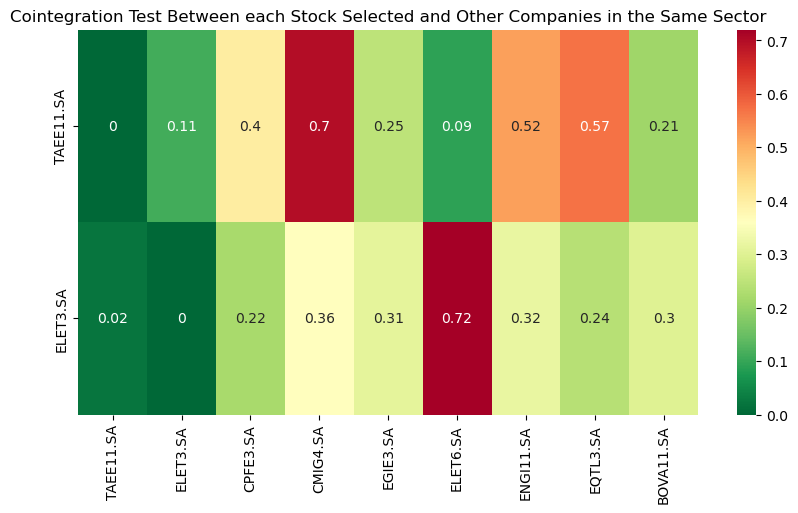

In [8]:
eletric_companies = ['TAEE11.SA', 'ELET3.SA', 'CPFE3.SA', 'CMIG4.SA', 'EGIE3.SA', 'ELET6.SA', 'ENGI11.SA', 'EQTL3.SA', 'BOVA11.SA']

def coint_test(stock, stock_list, df):
    """
    Returns the p-value for the cointegration test of stock with each item from stock_list.
    """

    coint_p_values = []

    # Compare the stock chosen with all the other from stock_list
    for i in stock_list:

        # If they are the same stock return 0, else get the p-value for the cointegration test
        if stock != i:
            coint_p_values.append(round(ts.coint(df[stock], df[i])[1], 2))
        else:
            coint_p_values.append(0)

    return coint_p_values

p_values = [coint_test(stock1, eletric_companies, df), coint_test(stock2, eletric_companies, df)]

plt.figure(figsize=(10, 5))
plt.title('Cointegration Test Between each Stock Selected and Other Companies in the Same Sector')
sns.heatmap(p_values, xticklabels=eletric_companies, yticklabels=[stock1, stock2], cmap="RdYlGn_r", annot=True)

As we can see the pair of stocks chosen are indeed cointegrated. Not only that, it seems that none of the stocks chosen are cointegrated either with the Bovespa Index (market) nor other companies in the same sector, which means that there could be no [confounding noise](https://en.wikipedia.org/wiki/Confounding) between the two companies.

## Plots

### Historical Closing Prices

It is hard to identify with certainty cointegrated pairs just by looking at their time series plot. However, we can see that in the long run both stocks tend to rise and drop concurrently.

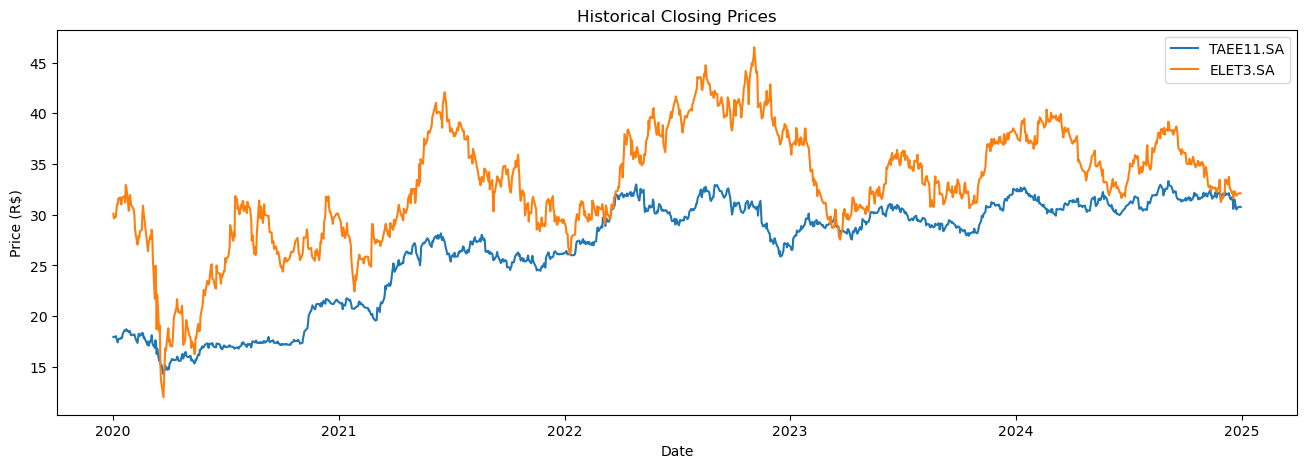

In [9]:
plt.figure(figsize=(16, 5))
plt.plot(df[stock1], label=stock1)
plt.plot(df[stock2], label=stock2)

plt.title("Historical Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (R$)")

plt.legend()
plt.show()

### Z Score

One way to see more clearly the simultaneous movements of each stock, is by calculating the [z-score](https://en.wikipedia.org/wiki/Standard_score) of the prices.

**The z-score or standard score is how far the raw value is from its mean, in number of standard deviations.** So if one observation has the z-score of +2, it means that the value of that observation is two standard deviations above the mean of that sample.

When we calculate the z-score of each variable, the difference in magnitude between them is irrelevant, since we are analyzing how much the values vary around its mean.

In [10]:
def zscore(data):
    """
    Calculates the z-score of each datapoint.
    """

    mean = data.mean()
    std = data.std()

    zscores = (data - mean) / std

    return zscores

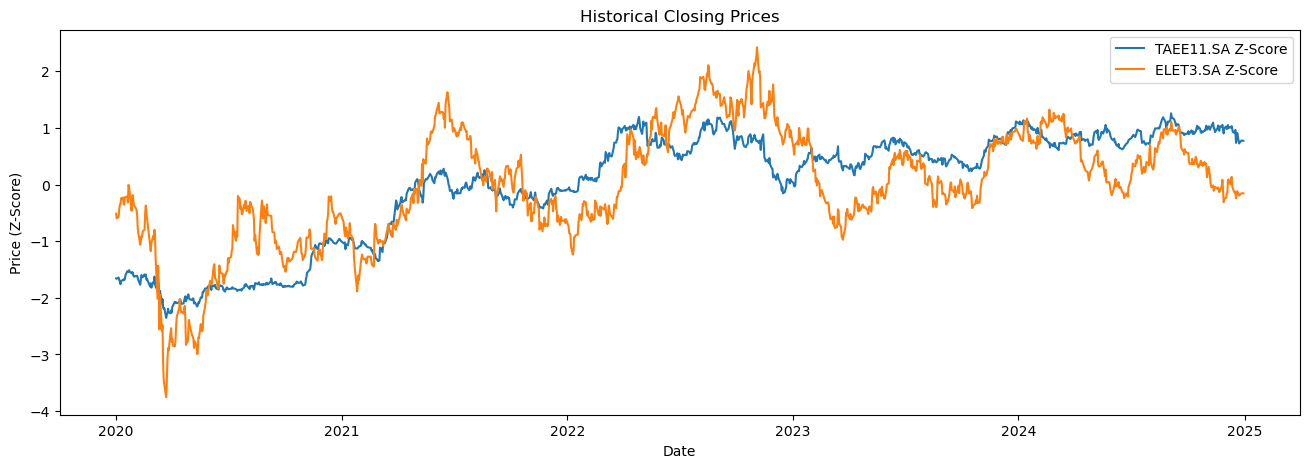

In [11]:
plt.figure(figsize=(16, 5))
plt.plot(zscore(df[stock1]), label=f'{stock1} Z-Score')
plt.plot(zscore(df[stock2]), label=f'{stock2} Z-Score')

plt.title("Historical Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (Z-Score)")

plt.legend()
plt.show()

Now, it is more apparent that they could be cointegrated.

### Spread

To calculate the spread, we'll use the same process from before: computing it as the difference between one price and the other times a factor (beta).

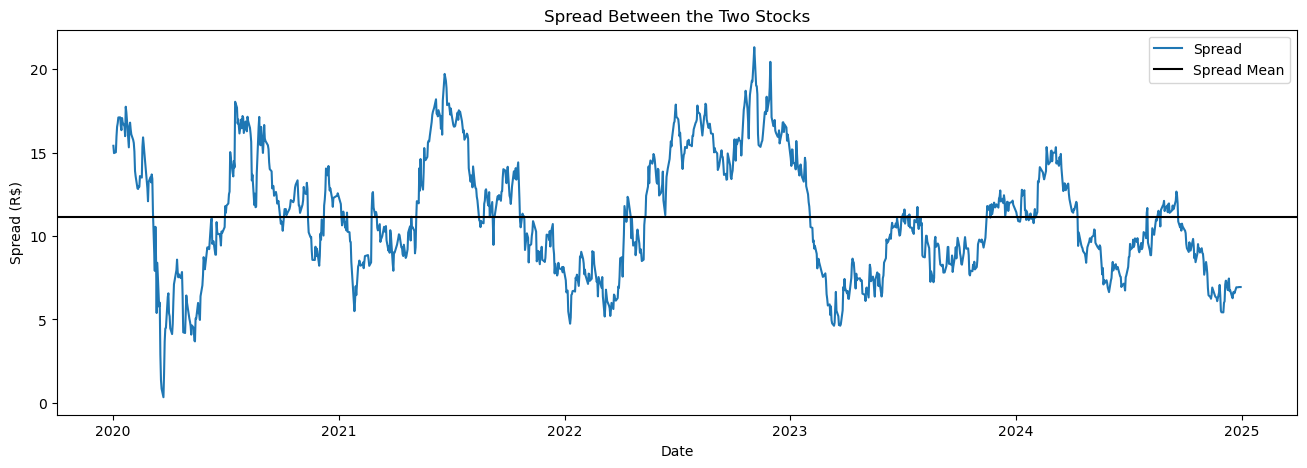

In [12]:
# Fit a linear regression to obtain beta
S1 = sm.add_constant(df[stock1])
results = sm.OLS(df[stock2], S1).fit()
beta = results.params[stock1]

spread = df[stock2] - beta * df[stock1]

plt.figure(figsize=(16, 5))

plt.plot(spread, label='Spread')
plt.axhline(spread.mean(), label='Spread Mean', color='black')

plt.title('Spread Between the Two Stocks')
plt.xlabel('Date')
plt.ylabel('Spread (R$)')

plt.legend()
plt.show()

As we checked previously, the spread between the two stocks is a stationary process, which tends to revert to a mean.

### Spread in Z-Score

Another way to visualize the stationarity, is by calculating the z-score of the spread. However, instead of calculating the z-score by using the mean and standard deviation of the whole sample, we'll use a moving window, since at every point in time we wouldn't have the data of future dates to calculate those statistics.

This time, the z-score represents how far the spread is from it's average. So, a high z-score means that the spread gap is getting wider, a low z-score means that the spread gap is getting narrower and a z-score close to 0 means that the spread gap is close to the mean.

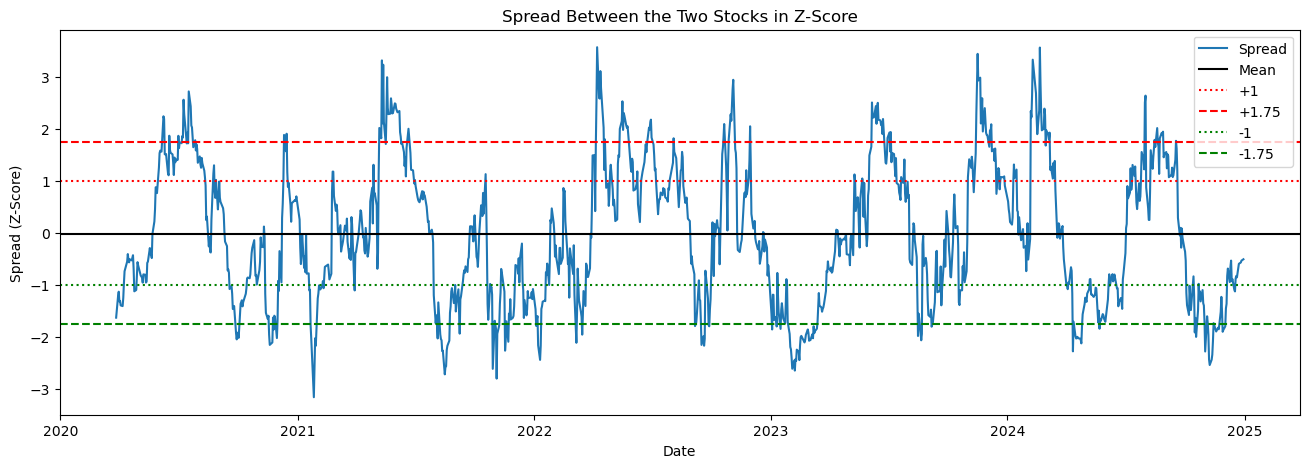

In [39]:
# Define the smaller and bigger window for the moving window method
window1 = 1
window2 = 60

# Calculates the z-scores using a moving window method
zscore_spread = (spread.rolling(window1).mean() - spread.rolling(window2).mean()) / spread.rolling(window2).std()

plt.figure(figsize=(16, 5))
plt.plot(zscore_spread, label='Spread')

plt.axhline(zscore_spread.mean(), color='black', label='Mean')
plt.axhline(1.0, color='red', linestyle='dotted', label='+1')
plt.axhline(1.75, color='red', linestyle='--', label='+1.75')
plt.axhline(-1.0, color='green', linestyle='dotted', label='-1')
plt.axhline(-1.75, color='green', linestyle='--', label='-1.75')

plt.title('Spread Between the Two Stocks in Z-Score')
plt.xlabel('Date')
plt.ylabel('Spread (Z-Score)')
plt.legend()
plt.show()

The plot above makes it clear that the process is stationary. Whenever the spread goes above +1.75 or below -1.75, it tends to reverting back to a mean.

So, a strategy we could apply is to buy the spread when it is below -1.75, and sell it when it goes above +1.75.

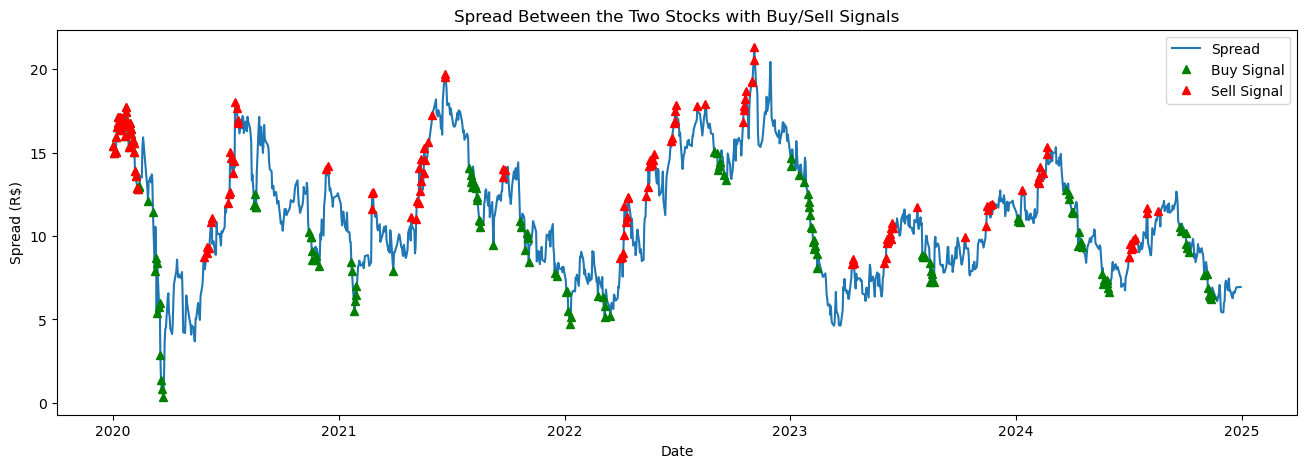

In [14]:
# Create copies of the spread series
buy = spread.copy()
sell = spread.copy()

# If the z-score is below -1.75, there is no buy signal
buy[zscore_spread > -1.75] = None

# If the z-score is above 1.75, there is no sell signal
sell[zscore_spread < 1.75] = None

plt.figure(figsize=(16, 5))

plt.plot(spread, label='Spread')
plt.plot(buy, color='green', linestyle='None', marker='^', label='Buy Signal')
plt.plot(sell, color='red', linestyle='None', marker='^', label='Sell Signal')

plt.title('Spread Between the Two Stocks with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Spread (R$)')
plt.legend()
plt.show()

The plot above shows the spread between the two stocks and the buy/sell signals raised whenever the z-score of the spread goes beyond a threshold of -1.75 or +1.75. As we can see the buy signals (green markers) tend to appear before the spread goes up, while the sell signals (red markers) tend to appear before the spread goes down.

### Spread with a Moving Beta

However, a major issue with the method above is that the beta coefficient was obtained through a regression on the entire sample. This is not correct, since this beta is being used to make a forecast for the strategy, and realistically, if you're running it in real-time, you wouldn't be have those future values to calculate beta.

For that reason, instead of calculating the beta using the whole time series, we'll do the same as we did for the z-score, **calculating the beta for each observation a moving window**.

Also, **we'll calculate the beta by dividing the covariance by the variance** of the two prices in that window. The reason for that is because in a smaller window days, the properties of cointegration (like an stable spread) don't apply, since cointegration only guarantees that the two variables move together in the long-run.

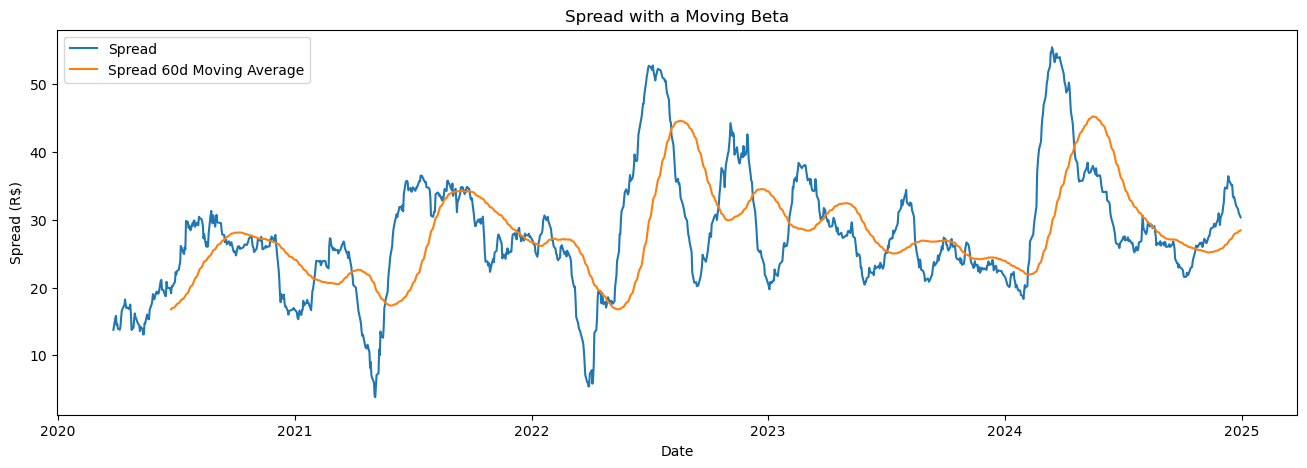

In [43]:
# Define a window for the moving window method
window = 60

# Calculate the covariance, variance and beta for each window
moving_cov = df[stock1].rolling(window).cov(df[stock2])
moving_var = df[stock2].rolling(window).var()
moving_beta = moving_cov / moving_var

# Calculate the spread for each point in the timeseries
spread_moving_beta = df[stock2] - moving_beta * df[stock1]

# Calculate a moving average to smooth the curve
spread_ma1 = spread_moving_beta.rolling(1).mean()
spread_ma2 = spread_moving_beta.rolling(window).mean()

plt.figure(figsize=(16, 5))

plt.plot(spread_ma1, label='Spread')
plt.plot(spread_ma2, label=f'Spread {window}d Moving Average')

plt.title('Spread with a Moving Beta')
plt.xlabel('Date')
plt.ylabel('Spread (R$)')
plt.legend()
plt.show()

As we can observe in the example above, the spread with a moving beta remains stationary, however it looks a lot more volatile than before. Since we are calculating the beta in a much smaller population, there is a higher chance of error and volatility.

### Spread with a Moving Beta in Z-Score

Similar to the first spread example, we can also visualize the spread in a z-score metric. But, instead of using the mean and standard deviation of the entire sample, we'll be also be using a moving window, since we don't have those future datapoints.

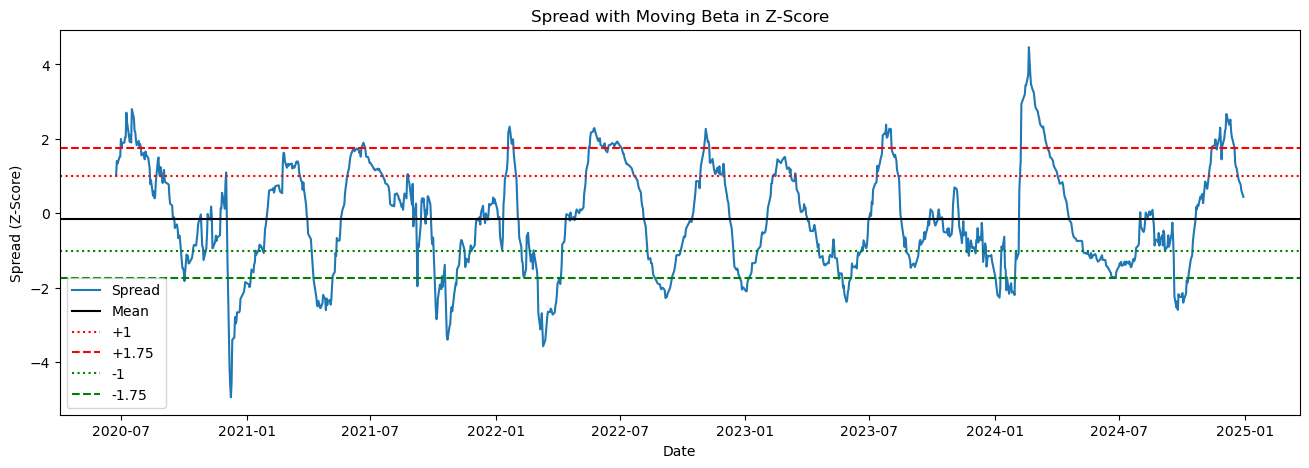

In [44]:
# Calculate the spread using the moving averages
zscore_30_1 = (spread_ma1 - spread_ma2) / spread_moving_beta.rolling(window).std()

plt.figure(figsize=(16, 5))
plt.plot(zscore_30_1, label='Spread')

plt.axhline(zscore_30_1.mean(), color='black', label='Mean')
plt.axhline(1.0, color='red', linestyle='dotted', label='+1')
plt.axhline(1.75, color='red', linestyle='--', label='+1.75')
plt.axhline(-1.0, color='green', linestyle='dotted', label='-1')
plt.axhline(-1.75, color='green', linestyle='--', label='-1.75')

plt.title('Spread with Moving Beta in Z-Score')
plt.xlabel('Date')
plt.ylabel('Spread (Z-Score)')
plt.legend()
plt.show()

Finally we can use the z-score above to create a trading strategy, buying the spread when it goes below -1.75 and selling it when it goes above +1.75.

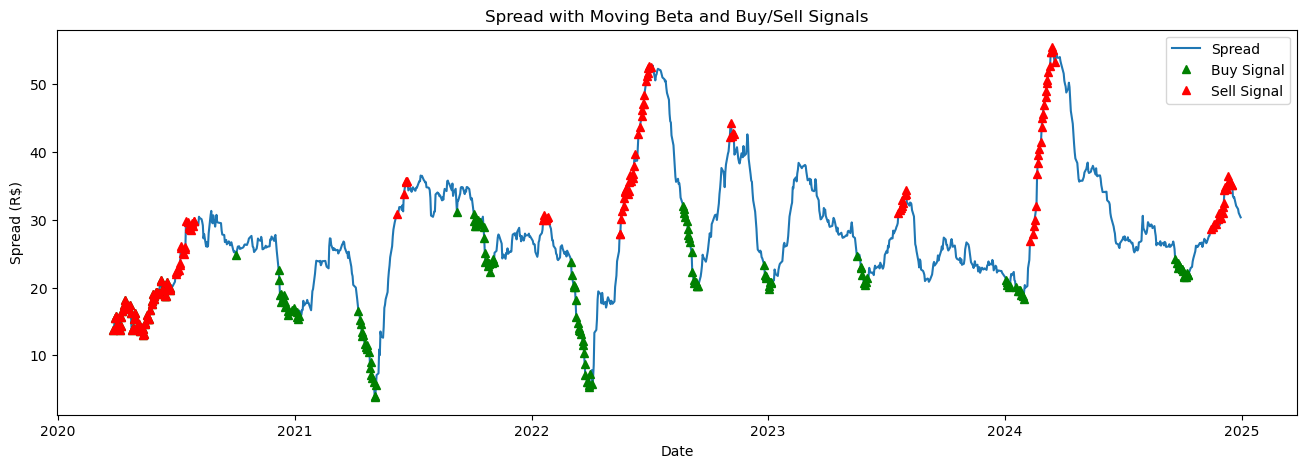

In [45]:
# Create copies of the spread series
buy = spread_moving_beta.copy()
sell = spread_moving_beta.copy()

# If the z-score is below -1.75, there is no buy signal
buy[zscore_30_1 > -1.75] = None

# If the z-score is above 1.75, there is no sell signal
sell[zscore_30_1 < 1.75] = None

plt.figure(figsize=(16, 5))

plt.plot(spread_moving_beta, label='Spread')
plt.plot(buy, color='green', linestyle='None', marker='^', label='Buy Signal')
plt.plot(sell, color='red', linestyle='None', marker='^', label='Sell Signal')

plt.title('Spread with Moving Beta and Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Spread (R$)')
plt.legend()
plt.show()

# Strategy Simulation

Finally we can use the signals generated to simulate a Pairs Trade strategy. For this implementation, **buying the spread means buying 1 unit of stock 2 while selling `moving_beta` units of stock 1**. On the other hand, s**horting the spread means selling 1 unit of stock 2 while buying `moving_beta` units of stock 1**. 

The reason we're buying and selling `moving_beta` units of stock, is because this strategy is market-neutral. Since the beta measures how much stock 2 moves from a unitary movement of stock 1, **by using beta as our hedge ratio, we can construct a portfolio where the movements of the two stocks are designed to cancel each other out**. That way we profit from the temporary "mispricing" and the spread's tendency to mean revert, not from the market's direction.

Since this strategy has a initial investment of 0, we don't calculate the return on initial investment. However, we will calculate the return on maximum capital deployed, which is the maximum amount of money that was tied up in our positions at any single point in time. This way, we can understand how efficiently our strategy generated profit relative to the biggest risk exposure it took.

--- Strategy Performance ---
Total Profit: R$83.19
Maximum Capital Deployed: R$55.77
Return on Maximum Capital: 149.15%


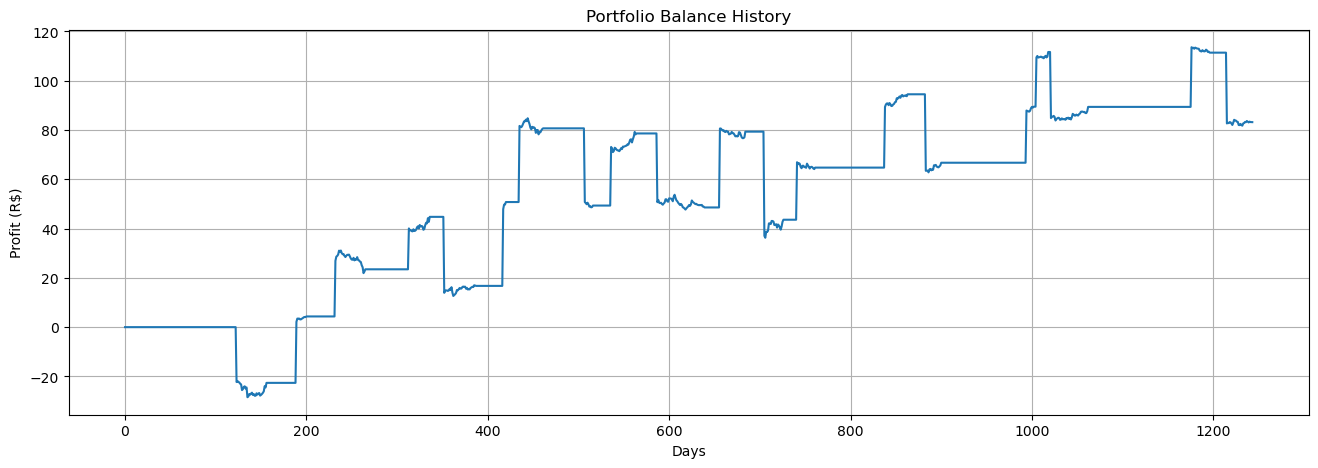

In [46]:
import numpy as np

def pair_trade(S1, S2, window1, window2):
    """
    Calculates the total return of a pairs trading strategy based on the
    maximum capital that was ever deployed in the portfolio.
    """
    # Ensure window lengths are valid
    if window2 < 2 or window1 < 1:
        return 0, 0, 0, []

    # 1. Spread Calculation
    moving_cov = S1.rolling(window=window2).cov(S2)
    moving_var = S2.rolling(window=window2).var()
    moving_beta = moving_cov / moving_var
    spread = S2 - moving_beta * S1
    spread_ma1 = spread.rolling(window=window1).mean()
    spread_ma2 = spread.rolling(window=window2).mean()
    spread_std = spread.rolling(window=window2).std()
    zscore = (spread_ma1 - spread_ma2) / spread_std

    # 2. Trading Simulation
    money = 0
    countS1 = 0
    countS2 = 0
    balance = []
    max_capital_deployed = 0  # Initialize max capital tracker

    for i in range(len(S1)):

        # Skip if signals are not valid
        if np.isnan(zscore.iloc[i]) or np.isnan(moving_beta.iloc[i]):
            balance.append(money)
            continue

        position_open = (countS2 != 0)

        # 2.1 Execute Trades Based on Z-Score

        # If the z-score is small, the gap is narrower, so we buy stock2 and sell stock1
        if zscore.iloc[i] < -1.75 and not position_open:
            countS2 = 1
            countS1 = -moving_beta.iloc[i]

        # If the z-score is big, the gap is wider, so we sell stock2 and buy stock1
        elif zscore.iloc[i] > 1.75 and not position_open:
            countS2 = -1
            countS1 = moving_beta.iloc[i]

        # If the z-score is closer to 0, the gap is close to its average, so we exit the trade
        elif abs(zscore.iloc[i]) < 0.75 and position_open:
            money += S1.iloc[i] * countS1 + S2.iloc[i] * countS2
            countS1 = 0
            countS2 = 0

        # 3. Track Capital Deployed

        # Capital deployed is the absolute market value of all positions
        current_capital = abs(S1.iloc[i] * countS1) + abs(S2.iloc[i] * countS2)
        
        # Update the maximum capital if the current value is higher
        max_capital_deployed = max(max_capital_deployed, current_capital)

        # Calculate mark-to-market portfolio value
        unrealized_pnl = S1.iloc[i] * countS1 + S2.iloc[i] * countS2
        total_value = money + unrealized_pnl
        balance.append(total_value)

    # 4. Total Profit Calculation
    total_profit = balance[-1] if balance else 0
    
    # Avoid division by zero if no trades were made
    if max_capital_deployed == 0:
        return 0, total_profit, 0, balance

    return_on_max_capital = total_profit / max_capital_deployed
    
    return return_on_max_capital, total_profit, max_capital_deployed, balance

roc, profit, max_capital, balance_history = pair_trade(df[stock1], df[stock2], 1, 60)

# Print the results
print("--- Strategy Performance ---")
print(f"Total Profit: R${profit:,.2f}")
print(f"Maximum Capital Deployed: R${max_capital:,.2f}")
print(f"Return on Maximum Capital: {roc:.2%}")

# Plot the equity curve
plt.figure(figsize=(16, 5))
plt.plot(balance_history)

plt.title('Portfolio Balance History')
plt.ylabel('Profit (R$)')
plt.xlabel('Days')
plt.grid()
plt.show()

The total profit doesn't seem that high, specially considering that the strategy was tested in a sample of 5 years. However, when we take into account that the simulation started with 0 money, and that the strategy was buying and selling 1 unit of stock, a 149.15% return on the maximum capital employed is more than acceptable.

### Sharpe Ratio
Even though the return on maximum capital was quite high, usually a portfolio performance is also measured using the Sharpe Ratio, which is a metric that also considers the risk associated with the strategy.

The Sharpe Ratio for my portfolio was very low, meaning that the daily returns from this strategy was extremely volatile. So, even though the strategy had a high return, the high risk associated with it meant that the strategy was probably not worth it.

# Next Steps
There are multiple ways to turn this method more robust, here is a list of possible next steps:

- Look for other stock pairs, using more qualitative methods.
- Try different methods to implement this strategy, other than a moving average (Kalman Filter, RNNs, etc.).
- Look for ways to reduce risk, increasing the Sharpe Ratio.

# Bibliography
The article was created using these videos as reference:

- [Introduction to Pairs Trading by Quantopian](https://www.youtube.com/watch?v=JTucMRYMOyY)

- [Quant Strategy: Pairs Trading Algorithm (Mean Reversion) by Spencer Pao](https://www.youtube.com/watch?v=f73ItMWO4z8)

- [Cointegration - an introduction by Ben Lambert](https://www.youtube.com/watch?v=vvTKjm94Ars)